<a href="https://colab.research.google.com/github/Mahsalo/Sparse_Regression_OvarianCancer/blob/master/CorrelatedGenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Mounting the Google Drive since I have put the files on my Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
### Importing the useful/required libraries
import pandas as pd
import numpy as np
from scipy.linalg import lu
import math
from scipy.stats import pearsonr
import seaborn as sns
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
#!pip install statsmodels



In [ ]:
### Reading the data into a data frame
### Each row is a gene and each column is a sample (Except for the first two columns)
### text_file below is actually the GTEX.nerve_samples.PMC5359387.txt file (name changed for convinience)
df =pd.read_csv("/content/gdrive/My Drive/text_file.txt",sep="\t")
df.head(5)

,Name,Description,GTEX.111CU.2226.SM.5N9G5,GTEX.111FC.0526.SM.5GZZ8,GTEX.111VG.2526.SM.5GZXP,GTEX.111YS.2126.SM.5EGGM,GTEX.113IC.0526.SM.5HL76,GTEX.117YX.2426.SM.5GZZJ,GTEX.1192X.0326.SM.5H11U,GTEX.11DXW.0426.SM.5H12E,GTEX.11DXX.2526.SM.5H119,GTEX.11DXZ.2526.SM.5N9BG,GTEX.11DYG.0426.SM.5987J,GTEX.11EI6.0426.SM.5EQ43,GTEX.11EQ9.2326.SM.5HL5H,GTEX.11GS4.2826.SM.5HL56,GTEX.11GSO.2626.SM.5Q5AK,GTEX.11GSP.2826.SM.5A5LK,GTEX.11H98.0426.SM.5HL55,GTEX.11LCK.1326.SM.5Q5AN,GTEX.11NSD.1826.SM.5N9CF,GTEX.11NUK.0426.SM.5HL5V,GTEX.11O72.0526.SM.5Q5AO,GTEX.11OC5.0526.SM.5N9EE,GTEX.11ONC.2326.SM.5HL6P,GTEX.11P7K.2226.SM.5GU56,GTEX.11P81.2626.SM.5GU6T,GTEX.11P82.1926.SM.5Q5AU,GTEX.11PRG.0126.SM.5BC55,GTEX.11TT1.2626.SM.5EGL2,GTEX.11TTK.0426.SM.5EQLT,GTEX.11UD2.0426.SM.5EQ5W,GTEX.11VI4.2126.SM.5EGI1,GTEX.11WQC.2826.SM.5GU7A,GTEX.11XUK.2326.SM.5CVLM,GTEX.11ZU8.2626.SM.5EQLL,GTEX.11ZUS.1226.SM.5FQU8,GTEX.11ZVC.2826.SM.5FQTC,GTEX.1211K.2326.SM.5FQU7,GTEX.12126.0626.SM.5Q5AQ,...,GTEX.YF7O.2626.SM.5IFHK,GTEX.YFC4.0826.SM.5CVM1,GTEX.YJ8A.0726.SM.5Q5A6,GTEX.YJ8O.2626.SM.5HL8H,GTEX.Z93S.0826.SM.5HL7Y,GTEX.Z9EW.2026.SM.5CVMQ,GTEX.ZA64.2126.SM.5Q5A8,GTEX.ZAB4.1826.SM.5HL8O,GTEX.ZAKK.0526.SM.5EGHC,GTEX.ZC5H.0526.SM.5HL9E,GTEX.ZDTS.0326.SM.5HL83,GTEX.ZDXO.1926.SM.5E45Q,GTEX.ZDYS.1526.SM.4WKFY,GTEX.ZF29.2626.SM.4WWBA,GTEX.ZF2S.2526.SM.5CVNT,GTEX.ZGAY.0826.SM.4WWEP,GTEX.ZLV1.2026.SM.5EQMB,GTEX.ZLWG.2526.SM.57WDS,GTEX.ZP4G.2226.SM.57WFB,GTEX.ZPCL.2426.SM.57WFP,GTEX.ZQG8.1326.SM.51MQW,GTEX.ZQUD.1226.SM.51MSP,GTEX.ZT9X.2126.SM.57WEV,GTEX.ZTPG.0526.SM.5O98W,GTEX.ZTX8.1726.SM.51MSB,GTEX.ZV68.0326.SM.59HJG,GTEX.ZVE2.0426.SM.59HJ7,GTEX.ZVT3.0326.SM.5GU6U,GTEX.ZVTK.0826.SM.5GZXI,GTEX.ZVZO.0526.SM.5A5LB,GTEX.ZVZP.2626.SM.51MR4,GTEX.ZXES.1926.SM.5E445,GTEX.ZXG5.0426.SM.5GICT,GTEX.ZYFC.0626.SM.5GIDR,GTEX.ZYFD.0426.SM.5E45X,GTEX.ZYFG.2526.SM.5GIEK,GTEX.ZYT6.1426.SM.5E43U,GTEX.ZYVF.0726.SM.5GICF,GTEX.ZYW4.0326.SM.5E44Y,GTEX.ZZ64.1426.SM.5NQ8C
0,ENSG00000115977.18,AAK1,5.620,5.590,4.450,6.610,5.900,4.310,5.840,7.52,2.220,6.04,5.91,7.430,5.750,6.150,7.49,6.650,6.420,5.42,7.87,4.810,7.640,4.640,4.380,5.47,7.630,4.590,7.36,5.980,7.350,6.820,5.83,7.91,6.190,6.520,5.95,5.360,5.560,6.07,...,6.140,5.70,5.8100,6.66,7.28,6.660,5.84,8.18,5.66,6.230,6.840,4.69,6.570,5.09,5.560,5.67,5.620,7.040,6.29,5.480,4.82,4.14,6.770,6.54,5.720,5.660,7.690,7.33,6.12,5.48,4.450,5.56,6.760,6.33,5.59,5.05,6.23,9.100,7.520,6.200
1,ENSG00000157985.18,AGAP1,11.300,24.600,14.000,13.700,12.500,14.000,15.900,21.40,8.300,18.90,23.80,23.700,19.400,11.800,22.40,17.300,19.000,15.30,17.20,22.300,11.100,21.300,13.100,17.10,31.700,8.670,16.10,20.300,23.500,16.700,16.80,15.40,19.600,13.000,21.80,13.500,12.800,16.40,...,12.600,13.00,14.9000,18.50,16.50,11.400,14.10,15.80,14.20,16.500,12.600,10.80,22.300,13.50,16.600,14.20,15.100,14.700,18.50,9.390,18.90,19.00,15.200,9.60,14.800,22.900,12.400,21.50,17.90,14.20,14.800,16.10,10.200,17.50,15.10,11.20,17.90,15.600,20.900,13.100
2,ENSG00000164691.16,TAGAP,1.180,11.000,9.870,6.880,15.800,10.000,6.310,13.80,3.820,7.08,17.40,5.050,3.540,6.930,6.46,9.570,4.310,6.94,5.47,5.930,8.210,7.050,12.400,2.33,6.050,2.610,8.08,0.815,6.320,6.590,4.45,12.30,6.550,10.700,10.30,11.300,5.610,4.67,...,4.060,12.10,4.0600,7.74,7.06,4.550,6.27,2.26,6.58,3.730,8.900,6.33,5.060,3.93,6.610,4.75,3.340,3.590,1.99,3.460,6.14,9.99,8.240,1.56,5.810,2.750,1.990,12.70,5.57,4.16,6.030,3.08,8.580,16.40,11.10,2.17,7.03,1.300,4.280,3.170
3,ENSG00000133612.18,AGAP3,36.400,56.400,42.400,40.900,35.400,29.000,46.100,39.10,30.500,40.30,37.40,47.300,41.300,33.000,38.00,48.900,31.800,38.80,38.60,39.800,42.800,41.100,39.600,37.40,51.000,24.600,43.20,25.900,44.200,35.300,38.70,51.70,35.100,39.900,49.30,40.100,35.200,64.90,...,42.800,43.60,39.5000,52.40,46.20,40.300,29.10,31.70,34.80,48.200,47.800,30.50,22.800,38.50,38.900,36.10,36.100,36.700,40.80,35.800,34.40,39.60,45.800,28.80,37.000,57.600,36.000,46.30,34.00,50.50,33.900,31.70,23.600,38.10,25.80,33.40,40.00,24.500,17.400,38.100
4,ENSG00000230869.1,AGAP10P,0.505,0

In [ ]:
genes, samples=df.shape
print("# of genes",genes)
print("# of samples",samples)

# of genes 1462
# of samples 621


In [ ]:
### Question 1: Finding the Pearson correlation matrix of genes
### Skipping the first two columns which include Gene Name and Description
df_genes = df.iloc[:,2:]

### Check for the Null/NAN/infinite values in the matrix
df_genes.replace([np.inf,-np.inf] , np.nan)
df_genes.dropna()

### For column-wise Pearson correlation, we need the traspose of the genes 
### dataframe above

df_genes_tr = df_genes.T
df_np = df_genes_tr.to_numpy()
pearson_c = np.corrcoef(df_np,rowvar=False) #column-wise correlation

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
### There would be a warning since some of the values of the correlation would be NaN
### That's because some columns of df_genes are completely zero and dividing by zero would cause NaN values

[s1,s2]=df_np.shape #samples*features
s = np.sum(df_np,axis = 0) # column-wise summation, we assume that the gene values are always positive
c = np.where(s==0)
df_genes_tr.drop(df_genes_tr.columns[c],axis=1,inplace = True) ##dropping the all_zero columns that cause problems
pearson_c_modified = np.corrcoef(df_genes_tr.to_numpy(),rowvar=False) #column-wise correlation
print(pearson_c_modified)

[[ 1.          0.19334328  0.10063297 ...  0.06295295  0.29146895
   0.09632194]
 [ 0.19334328  1.          0.19622774 ...  0.02771449  0.00374515
   0.29888801]
 [ 0.10063297  0.19622774  1.         ... -0.01642164  0.03339608
   0.3999277 ]
 ...
 [ 0.06295295  0.02771449 -0.01642164 ...  1.          0.66888606
   0.182699  ]
 [ 0.29146895  0.00374515  0.03339608 ...  0.66888606  1.
   0.17424759]
 [ 0.09632194  0.29888801  0.3999277  ...  0.182699    0.17424759
   1.        ]]


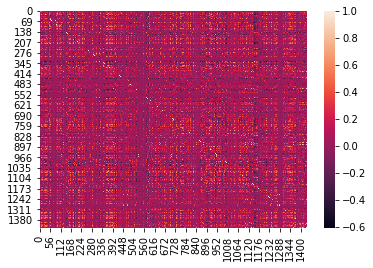

In [ ]:
sns.heatmap(pearson_c_modified)


**Question 2:** 
Since the correlation matrix is symmetric, LU decomposition is useful.
We extract the upper-triangle and find the top 10 highest values disregarding the diagonals which are always 1.

In [ ]:
p, l, u = lu(pearson_c_modified)
[s3,s4]= l.shape
diff_main = l-np.eye(s3)
diff = diff_main.flatten()
sorted = np.sort(diff)
ten_most_correlated = sorted[::-1][0:10]
ten_most_anticorrelated = sorted[0:10]
ten_most_correlated_pairs = []
ten_most_anticorrelated_pairs = []

for i in range(10):
  ind = ten_most_correlated[i]
  x = np.where(diff_main == ind)
  ten_most_correlated_pairs.append(x)
  ind2 = ten_most_anticorrelated[i]
  y = np.where(diff_main==ind2)
  ten_most_anticorrelated_pairs.append(y)

print("Ten most correlated genes",ten_most_correlated_pairs)
print("Ten most anticorrelated genes",ten_most_anticorrelated_pairs)


Ten most correlated genes [(array([1309]), array([1265])), (array([1144]), array([767])), (array([662]), array([658])), (array([1275]), array([1150])), (array([1394]), array([1379])), (array([1362]), array([1333])), (array([1237]), array([777])), (array([668]), array([658])), (array([1371]), array([1367])), (array([748]), array([706]))]
Ten most anticorrelated genes [(array([968]), array([965])), (array([1371]), array([885])), (array([1119]), array([994])), (array([1317]), array([1316])), (array([1432]), array([1284])), (array([1126]), array([812])), (array([992]), array([913])), (array([1396]), array([1168])), (array([1226]), array([1041])), (array([569]), array([566]))]


The following function takes X (dataframe with dimensions samples*genes) 
and k (k top correlated/anticorrelated genes) as input arguments.
The output is the list containing the indices of the k-top correlated and 
k-top anti-correlated genes. We can see that the results are the same as above for k=10.

In [ ]:
def correlated(X,k):
  df_np = X.to_numpy()
  pearson_c = np.corrcoef(df_np,rowvar=False) 
  [s1,s2]=df_np.shape 
  s = np.sum(df_np,axis = 0) 
  c = np.where(s==0)
  X.drop(X.columns[c],axis=1,inplace = True) ##dropping the all_zero columns that cause problems
  pearson_c_modified = np.corrcoef(X.to_numpy(),rowvar=False) #column-wise correlation
  
  p, l, u = lu(pearson_c_modified)
  [s3,s4]= l.shape
  print(l)
  diff_main = l-np.eye(s3)
  diff = diff_main.flatten()
  #print(diff)
  sorted = np.sort(diff)
  k_most_correlated = sorted[::-1][0:10]
  k_most_anticorrelated = sorted[0:10]
  k_most_correlated_pairs = []
  k_most_anticorrelated_pairs = []

  for i in range(10):
    ind = k_most_correlated[i]
    x1 = np.where(diff_main == ind)
    k_most_correlated_pairs.append(x1)
    ind2 = k_most_anticorrelated[i]
    x2 = np.where(diff_main==ind2)
    k_most_anticorrelated_pairs.append(x2)
  return  k_most_correlated_pairs  


In [ ]:
correlated(df_genes.T,10)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.93343275e-01  1.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00632967e-01  1.83635625e-01  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 4.32175837e-01 -4.88659674e-02  5.70823217e-04 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.92132039e-02  5.72774056e-01 -3.75837244e-02 ...  9.35453922e-01
   1.00000000e+00  0.00000000e+00]
 [ 8.07647055e-02  5.91622771e-03 -3.38978573e-02 ... -5.33503133e-01
  -4.49341785e-01  1.00000000e+00]]


[(array([1309]), array([1265])),
 (array([1144]), array([767])),
 (array([662]), array([658])),
 (array([1275]), array([1150])),
 (array([1394]), array([1379])),
 (array([1362]), array([1333])),
 (array([1237]), array([777])),
 (array([668]), array([658])),
 (array([1371]), array([1367])),
 (array([748]), array([706]))]

**Question 3:**
First we need to consider the pair of (x1,x2) as independent variables
Then we can assume that the rest of the genes are dependent variables

In [ ]:

gene_num = df_genes_tr.shape[1]
L = np.arange(gene_num)
D = {}
D_tot={}
for i in ten_most_correlated_pairs:
  # Pairings
  gene1 = int(i[0])
  gene2 = int(i[1])

  unwanted_list={gene1,gene2} ##exclude them from the list
  L_modified = [element for element in L if element not in unwanted_list]

  for j in L_modified:

    z = j
    dfxz = df_genes_tr.iloc[:,[gene1,z]]
    dfyz = df_genes_tr.iloc[:,[gene2,z]]
    dfxy = df_genes_tr.iloc[:,[gene1,gene2]]

    ### Pearson correlations and two-sided p-values 
    XZ = stats.pearsonr(df_genes_tr.iloc[:,gene1],df_genes_tr.iloc[:,z])
    YZ = stats.pearsonr(df_genes_tr.iloc[:,gene2],df_genes_tr.iloc[:,z])
    XY = stats.pearsonr(df_genes_tr.iloc[:,gene1],df_genes_tr.iloc[:,gene2])

    ### Pearson correlation  
    xz = XZ[0]
    yz = YZ[0]
    xy = XY[0]

    ### P-values
    xzp = XZ[1]
    yzp = YZ[1]
    xyp = XY[1]


    ### P-value corrections
    pvals = [xzp,yzp]
    res = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

    Rxyz = math.sqrt((abs(xz**2) + abs(yz**2) - 2*xz*yz*xy) / (1-abs(xy**2)) )
    R2 = Rxyz**2

    # Calculate adjusted R-squared
    N = samples
    indp = 2       # Number of independent variables
    R2_adj = 1 - ( ((1-R2)*(N-1)) / (N-indp-1) )

    # Considering the thresholds on the p-values and 
    if Rxyz>=0.7:
      if True in res[0]:
        print(res[0])
        D[(gene1,gene2)]=(Rxyz,z)
    D_tot[(gene1,gene2)]=(Rxyz,z)
       


[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[ True  True]
[ True  True]
[ True False]
[ True False]
[ True  True]
[ True False]
[ True  True]
[False  True]
[ True  True]
[ True False]
[ True False]
[ True False]
[ True  True]
[ True False]
[ True False]
[ True False]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True False]
[ True False]
[ True False]
[ True  True]
[ True  True]
[ True  True]
[ True False]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[False  True]


In [ ]:
print(D)

{(1309, 1265): (0.8118325170822949, 1399), (1144, 767): (0.7624554961062685, 1370), (662, 658): (0.7345740090652857, 1410), (1275, 1150): (0.7272002419092901, 1375), (1237, 777): (0.7237113979914137, 1288), (668, 658): (0.86510132998681, 1425), (1371, 1367): (0.7118216970525916, 1409), (748, 706): (0.7145513913440769, 904)}


**Question 4: **

Since we are comparing the correlation of several genes simultanously,  we need to do multiple hypothesis testing.In order to identify significance in terms of changes between two groups, it is necessary to apply multiple hypothesis testing (analysis of hypothesis across thousands of genes simultaneously). Each individual hypothesis testing for a single gene involves whether mean of two groups are different or not.In order to avoid Type 1 and Type 2 errors we need to do p-value correction/adjustments. Type 1 error will increase in multiple hypothesis testing. The simplest way to adjust your P values is to use the conservative Bonferroni correction method which multiplies the raw P values by the number of tests m (i.e. length of the vector P_values)

**Question 5:**
In order to have a heatmap (2D graphical representation) we need to have a 2D array and assign a value to each pair of coordinates. Here, one coordinate is a tuple(gene1,gene2) and the other coordinate is the other gene and the value assigned to the is the Rxyz.
The heatmap that I show below, has ten highly correlated pairs as y-axis and the whole gene-set as x-axis so because the dimensions are so different most of the heatmap is showing black (zero). But I think there exists some clusters since the third gene that is. related to the pair is mostly located at the higher values of gene numbers (>1300). 

In [ ]:

dict_len = len(D_tot) ##Total number of correlated pairs
axis1 = np.arange(dict_len)
axis2 = np.arange(gene_num)
heatm = np.zeros((dict_len,gene_num))
J = 0
for K in D_tot.keys():
  x = D_tot[K]
  z = int(x[1])
  val = x[0]
  
  heatm[J,z]=val 
  J +=1


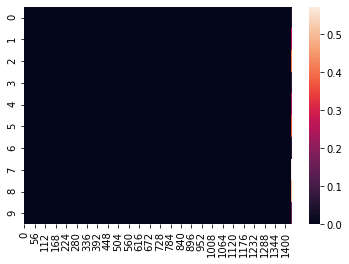

In [ ]:
sns.heatmap(heatm)